# Identificazione delle Anchor Box

In questo notebook vedremo come identificare e generare le anchor box e come assegnare uno score per selezionare quelle che saranno poi effettivamente analizzate dalle fasi succesive della pipeline di object detection.

L'obiettivo è individuare le top-k anchor box che presumibilmente contengono gli oggetti presenti nell'immagine. 
Il flusso di esecuzione prevede:

1. Estrazione delle feature
2. Individuazione delle anchor box
3. Calcolo dell'*objectness score* tramite un rete RPN
4. Selezione delle top-k


In [111]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# in questa folder sono memorizzati alcuni file a supporto (path relativo al notebook corrente)
IMGSRC = 'lion.jpg'

image = pil2tensor(Image.open(IMGSRC))

# fake batch dimension => shape is (1, 3, 800, 800)
image4D = image.unsqueeze(0)

Shape del tensore: torch.Size([3, 800, 800])


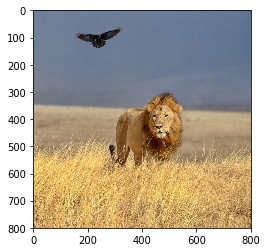

In [112]:
def plot_image(tensor):
    plt.figure()
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

print(f'Shape del tensore: {image.shape}')    
plot_image(image)

# 1. Estrazione delle feature

Il primo passo è quello di estrarre le feature dall'immagine. Possiamo utilizzare qualsiasi algoritmo compatibile con il dominio così da avere delle feature significative per le immagini che dobbiamo analizzare, in questo caso utilizziamo una VGG16 pre-addestrata sul dataset ImageNet.

In [4]:
model = torchvision.models.vgg16(pretrained=True, progress=False)

In [5]:
# il modello riconosce l'immagine?
with torch.no_grad():
    model.eval()

    out = model(image.unsqueeze(0))
    ps = torch.exp(out)

    # Find the topk predictions
    _, topclass = ps.topk(1, dim=1)

    idx_class = topclass[0][0]
    
with open('imagenet_labels.json') as fp:
    labels = json.load(fp)

detected_class = labels[str(idx_class.item())]

print(f'detected class by Vgg16 is "{detected_class}"')

detected class by Vgg16 is "lion, king of beasts, Panthera leo"


## Identificazione della feature map

L'obiettivo è estrarre tramite il modello VGG16 le feature map di dimensione prefissata, quindi è necessario ottenere l'output dell'i-esimo livello della VGG tale che la dimensione del tensore di output sia pari alla dimensione target.

L'immagine analizzata ha una dimensione di 800x800. Ipotizziamo di suddividerla in 16 subsample e per ognuno estraiamo una feature map di dimensione pari a 800//16, quindi 50x50.

Il nostro obiettivo è calcolare una feature map 50x50 e quindi ci servono le feature estratte dal livello 30 della VGG. Questo livello può essere individuato in automatico controllando la shape dei tensori ad ogni livello e selezionando quello compatibile con il nostro obiettivo.


In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [136]:
# VGG16 feature map levels
fe = list(model.features)

req_features = []
test_image = image4D.clone()

out_channels = None
for level in fe:
    test_image = level(test_image)
    
    if test_image.shape[2] < 800 // 16:
        break
    
    # store current level and its output
    req_features.append(level)
    out_channels = test_image.shape[1]

print(f'number of levels extracted: {len(req_features)}')  # 30
print(f'dimension of the last level: {out_channels}')  # 512

# build my feature extractor
faster_rcnn_fe_extractor = nn.Sequential(*req_features)
out_map = faster_rcnn_fe_extractor(image4D)
print(f'Shape of the input image processed by FE extractor: {out_map.shape}')

number of levels extracted: 30
dimension of the last level: 512
Shape of the input image processed by FE extractor: torch.Size([1, 512, 50, 50])


### Step 2

Adesso abbiamo il nostro feature extractor e dobbiamo individuare tutte le possibili anchor box. Poiché vogliamo utilizziamo un fattore di subsampling pari a 16, allora dobbiamo individuare anchor box di dimensione pari a 16x16 pixel.

I parametri per individuare le anchor box sono:

- Posizione x, y
- Scala **s**: 8, 16, 32
- Aspect ratio  **r** = $a^2$: 0.5, 1, 2

Per ogni pixel generiamo tutte le possibili anchor box, cioé per ogni valore di scala e per ogni valore di aspect ratio. Quindi sono 9 anchor box, ognuna definita dalla quadrupla $x_1, y_1, x_2, y_2$

La dimensione di ogni anchor box sarà ottenute utilizzando i seguenti coefficienti

$$ h = s * a $$
$$ w = \frac{s}{a}    $$

In [17]:
def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    
    py = base_size / 2
    px = base_size / 2

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)

    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            # [y_min, x_min, y_max, x_max]
            anchor_base[index, 0] = py - h / 2
            anchor_base[index, 1] = px - w / 2
            anchor_base[index, 2] = py + h / 2
            anchor_base[index, 3] = px + w / 2
            
    return anchor_base

sub_sample = 16
ratio = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

anchor_base = generate_anchor_base(sub_sample, ratio, anchor_scales)

print(anchor_base)

[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 [ -56.        -56.         72.         72.      ]
 [-120.       -120.        136.        136.      ]
 [-248.       -248.        264.        264.      ]
 [ -82.50967   -37.254833   98.50967    53.254833]
 [-173.01933   -82.50967   189.01933    98.50967 ]
 [-354.03867  -173.01933   370.03867   189.01933 ]]


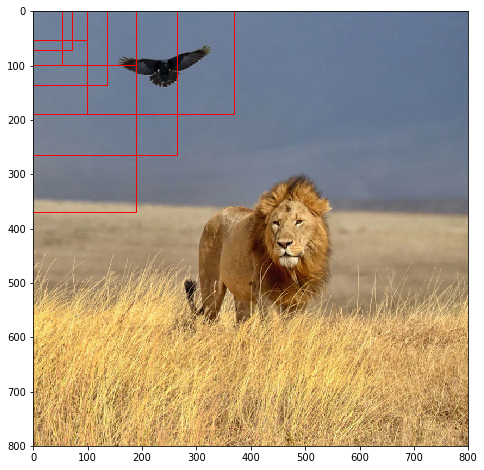

In [113]:
import matplotlib.patches as patches

def plot_bbox(image_tensor, bbox_list):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 8)

    ax.imshow(image_tensor.numpy().transpose(1, 2, 0))

    for bbox_idx in range(bbox_list.shape[0]):
        x1, y1, x2, y2 = bbox_list[bbox_idx, :].tolist()

        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        ax.add_patch(rect)

    plt.show();
    
plot_bbox(image, anchor_base)

In questo caso gli anchor box sono stati calcolati considerando come centro del box il pixel (0, 0), quindi viene selezionata parte dell'immagine al di fuori del frame.

Effettuando uno shift al centro dell'immagine otteniamo questo risultato. Il processo di calcolo degli anchor box deve essere iterato per tutti i pixel della feature map, quindi si ottengono 50 * 50 * 9 = 22500 possibili anchor box

Una possibile soluzione è eseguire una doppia iterazione su tutti i possibili shift:

    for i in shift_x:
        for j in shift_y:
            compute 9 boxes on (i, j)
            
L'alternativa è calcolare tutti i possibili shift (800/16 = 50) e sommare questo shift ai 9 anchor box di base

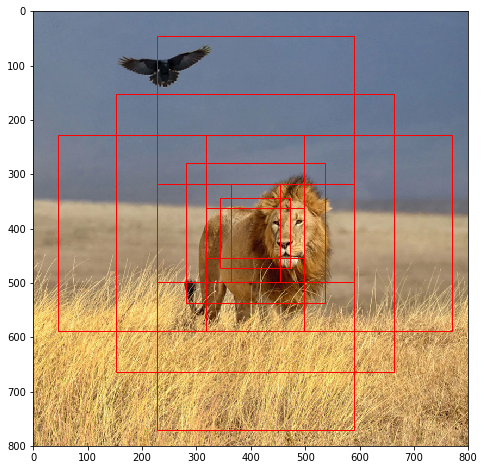

In [114]:
# place center at (400, 400)
anchor_at_400_400 = anchor_base + 400
plot_bbox(image, anchor_at_400_400)

In [93]:
# compute all possible anchor box
W, H = image.shape[1:]  # 800x800
shift_x = np.arange(0, W, sub_sample)  # stride=16
shift_y = np.arange(0, H, sub_sample)

# build shift matrix on xy, each with shape 50x50
# each point is the x/y coordinate of the anchor boxes centre
shift_matrix_x, shift_matrix_y = np.meshgrid(shift_x, shift_y)

print(f'matX shape = {shift_matrix_x.shape}')
print(shift_matrix_x)
print(f'matY shape = {shift_matrix_y.shape}')
print(shift_matrix_y)
print('_' * 40)

# merge matrices row by row (so axis=1) and duplicate pair to have 4 dimension
# y is before x in the sequence of stack method to plot all y coord for each x
shift = np.stack((shift_matrix_y.ravel(), shift_matrix_x.ravel(), shift_matrix_y.ravel(), shift_matrix_x.ravel()), axis=1)
print(f'shift shape = {shift.shape}') # 2500 x 4

K = shift.shape[0]
boxes, coord = anchor_base.shape  # 9 x 4

# compute shift
# base is 9 x 4 -> 1 x 9 x 4
# shift is 2500 x 4 -> 2500 x 1 x 4 (with transpose)
# result is (2500*9) x 4
anchors = anchor_base.reshape((1, boxes, coord)) + shift.reshape((1, K, coord)).transpose((1, 0, 2)) #（K, 9, 4)
print(f'anchor shape = {anchors.shape}')

anchors = anchors.reshape((K * boxes, 4)).astype(np.float32)

print(f'anchor boxes = {anchors.shape}')

matX shape = (50, 50)
[[  0  16  32 ... 752 768 784]
 [  0  16  32 ... 752 768 784]
 [  0  16  32 ... 752 768 784]
 ...
 [  0  16  32 ... 752 768 784]
 [  0  16  32 ... 752 768 784]
 [  0  16  32 ... 752 768 784]]
matY shape = (50, 50)
[[  0   0   0 ...   0   0   0]
 [ 16  16  16 ...  16  16  16]
 [ 32  32  32 ...  32  32  32]
 ...
 [752 752 752 ... 752 752 752]
 [768 768 768 ... 768 768 768]
 [784 784 784 ... 784 784 784]]
________________________________________
shift shape = (2500, 4)
anchor shape = (2500, 9, 4)
anchor boxes = (22500, 4)


(4,)
[[264.        40.       776.       552.      ]
 [429.49033  250.74516  610.50964  341.25482 ]
 [338.98065  205.49033  701.01935  386.50967 ]
 [157.96133  114.98067  882.0387   477.01935 ]
 [474.74518  221.49033  565.2548   402.50967 ]
 [429.49033  130.98067  610.50964  493.01935 ]
 [338.98065  -50.038666 701.01935  674.0387  ]
 [456.       248.       584.       376.      ]
 [392.       184.       648.       440.      ]]


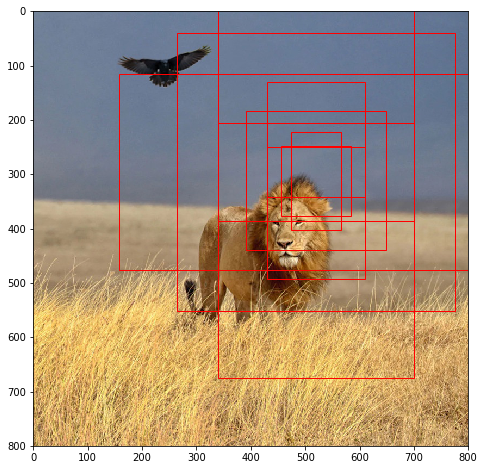

In [115]:
# an example
idx = 14567
print(anchors[idx].shape)
print(anchors[idx:idx+9])  # select 9 boxes
plot_bbox(image, anchors[idx:idx+9])

### Step 3

Assegniamo una label ad ogni anchor box.

Questo procedimento prevede l'etichettatura sia di esempi positivi che di esempi negativi sfruttando il concetto di **IoU** (Intersection-over-Union).

- Una label positiva è assegnata alle anchor con il maggior **IoU** con la ground-truth-box (la true label) e a quelle che hanno un rapporto maggiore di una soglia (0.7)
- Una label negativa è assegnata alle anchor che hanno un valore di **IoU** inferiore ad una soglia (0.3)
- Le anchor non etichettate non vengono considerate nella fase di training


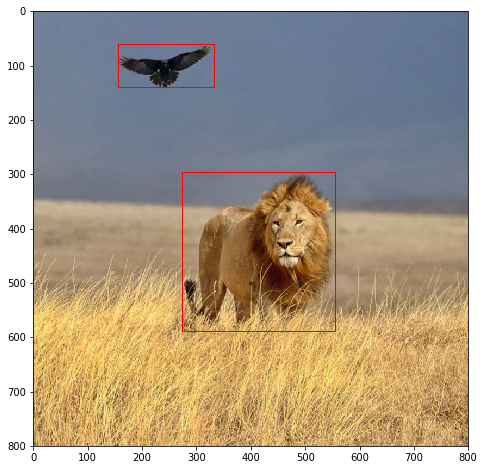

In [120]:
ground_truth_box = np.asarray([[155, 61, 332, 140], [274, 296, 555, 588]], dtype=np.float32)
plot_bbox(image, ground_truth_box)

**Strategia**
Filtro le anchor box al di fuori dell'immagine e etichetto in funzione dei valori IoU

In [122]:
# filter anchors inside the image

W, H = image.shape[1:]  # 800x800

inside_indexes = np.where(
    (anchors[:, 0] >= 0) &
    (anchors[:, 1] >= 0) &
    (anchors[:, 2] <= W) &
    (anchors[:, 3] <= H)
)[0]

print(inside_indexes.shape)

bbox_labels = np.empty((len(inside_indexes),), dtype=np.int32)
bbox_labels.fill(-1)
print(bbox_labels.shape)

valid_anchor_boxes = anchors[inside_indexes]
print(valid_anchor_boxes.shape)

(8940,)
(8940,)
(8940, 4)


Per ogni anchor box valida devo calcolare il valore di **ioU** con le ground-truth-box.

La strategia per calcolare il valore IoU tra 2 box è la seguente:

    - Find the max of x1 and y1 in both the boxes (xn1, yn1)
    - Find the min of x2 and y2 in both the boxes (xn2, yn2)
    - Now both the boxes are intersecting only
     if (xn1 < xn2) and (yn2 < yn1)
          - iou_area will be (xn2 - xn1) * (yn2 - yn1)
     else
          - iuo_area will be 0
    - similarly calculate area for anchor box and ground truth object
    - iou = iou_area/(anchor_box_area + ground_truth_area - iou_area)



In [124]:
num_boxes = 2  # true label

ious = np.zeros((len(valid_anchor_boxes), num_boxes), dtype=np.float32)

for idx, valid_box in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = valid_box
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    
    for idx_true, true_box in enumerate(ground_truth_box):
        yb1, xb1, yb2, xb2 = true_box
        box_area = (yb2 - yb1) * (xb2 - xb1)

        inter_x1 = max(xb1, xa1)
        inter_y1 = max(yb1, ya1)
        inter_x2 = min(xb2, xa2)
        inter_y2 = min(yb2, ya2)

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.

        ious[idx, idx_true] = iou

print(ious.shape)

(8940, 2)


In [125]:
# the highest iou for each ground truth box and its corresponding anchor box
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[1979 4620]
[0.8314627 0.798713 ]


In [127]:
# the highest iou for each anchor box and its corresponding ground truth box

argmax_ious = ious.argmax(axis=1) # only one object. it is 0
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(ious)), argmax_ious]
print(max_ious)

# boxes with max iou
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[1979 4620 4628 4636 4894 4902 4910]


Adesso assegno le label con questa logica

*argmax_ious* contiene gli indici dei valori massimi di IoU di ogni box con la ground truth box  
*max_ious* contiene i valori massimi di IoU di ogni box con la ground truth box  
*gt_argmax_ious* indica quali sono i boxes che hanno intersezione massima con ground truth box  

- si assegna una label negativa (0) agli anchor box che hanno IoU inferiore al massimo
- si assegna una label positiva (1) agli anchor box che hanno IoU pari al massimo oppure maggiore della soglia

Si fissa un rapporto 1:1 tra esempi positivi e negativi e si limitano ad un certo numero.

Se il numero di esempi positivi è inferiore al target, si aggiungono degli esempi negativi random.
Se il numero di esempi positivi è superiori al target, si eliminano degli esempi positivi random.

In [128]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

bbox_labels[max_ious < neg_iou_threshold] = 0
bbox_labels[gt_argmax_ious] = 1
bbox_labels[max_ious >= pos_iou_threshold] = 1

pos_ratio = 0.5
n_sample = 256
n_pos = pos_ratio * n_sample

pos_index = np.where(bbox_labels == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    bbox_labels[disable_index] = -1

# negative    
n_neg = n_sample - np.sum(bbox_labels == 1)
neg_index = np.where(bbox_labels == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
    bbox_labels[disable_index] = -1

### Step 4

Adesso si devono calcolare le posizioni delle anchor box etichettate rispetto alla posizione della ground truth box

1. cerco le anchor con valore massimo di IoU rispetto alla ground true box
2. cerco il centro di ogni anchor, quindi da (x1,y1,x2,y2) a (x,y,w,h)
3. calcolo le posizioni relative
4. calcolo il vettore delle label

In [132]:
# step 1
max_iou_bbox = ground_truth_box[argmax_ious]
print(max_iou_bbox)

# step 2
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = (max_iou_bbox[:, 2] - max_iou_bbox[:, 0])
base_width = (max_iou_bbox[:, 3] - max_iou_bbox[:, 1])
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# step 3
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs)

# step 4
# necessary because of the output of the net
anchor_labels = np.empty((len(anchors),), dtype=bbox_labels.dtype)
anchor_labels.fill(-1)
anchor_labels[inside_indexes] = bbox_labels

anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[inside_indexes, :] = anchor_locs

anchor_labels.shape, anchor_locations.shape

[[155.  61. 332. 140.]
 [155.  61. 332. 140.]
 [155.  61. 332. 140.]
 ...
 [155.  61. 332. 140.]
 [155.  61. 332. 140.]
 [155.  61. 332. 140.]]
[[ 2.0716019  -0.01933499  0.670693   -0.8291561 ]
 [ 2.0716019  -0.10772333  0.670693   -0.8291561 ]
 [ 2.0716019  -0.19611163  0.670693   -0.8291561 ]
 ...
 [-5.5297976  -3.112928    0.67069334 -0.82915574]
 [-5.5297976  -3.2013164   0.67069334 -0.82915574]
 [-5.5297976  -3.2897048   0.67069334 -0.82915574]]


((22500,), (22500, 4))

# Estrazione delle feature per ogni anchor box

Creaiamo una NN che sfrutti le features estratte dalla VGG e che restituisca le Region Proposal

![RPN](rpn.png)

In [135]:
mid_channels = 512
in_channels = 512  # depends on the output feature map. in vgg 16 it is equal to 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)

# conv sliding layer
# initialization (as in the paper)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()  # Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()  # classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_();

In [140]:
# compute the locations of objects with repect to the anchor and the objectness score

print(f'feautures shape: {out_map.shape}')

x = conv1(out_map)  # out_map is tensor returned by fe_extractor for the input image

pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(f'score shape: {pred_cls_scores.shape}, loc shape: {pred_anchor_locs.shape}')

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(f'pred_anchor_locs: {pred_anchor_locs.shape}')

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(f'objectness_score: {objectness_score.shape}')

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(f'pred_cls_scores: {pred_cls_scores.shape}')

feautures shape: torch.Size([1, 512, 50, 50])
score shape: torch.Size([1, 18, 50, 50]), loc shape: torch.Size([1, 36, 50, 50])
pred_anchor_locs: torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
objectness_score: torch.Size([1, 22500])
pred_cls_scores: torch.Size([1, 22500, 2])


# Risultati
A questo punto abbiamo:

1. **pred_cls_scores** contiene gli score sulle classi (è l'ouput del classification layer della RPN)
2. **pred_anchor_locs** contiene le posizioni relative (è l'ouput del regression layer della RPN)
3. **objectness_scores** e **pred_cls_scores** diventano gli input delle le fasi successive
4. **anchor_labels** contiene le label assegnati agli anchor box selezionati nelle fasi precedenti
5. **anchor_locations** contiene le posizione relative degli anchor box selezionati nelle fasi precedenti
